In [1]:
import datetime as dt
import win32com.client as win32
import calendar as cld
import pyodbc
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import os
from time import sleep
from tqdm import tqdm
from gc import collect
from Supporter import ReportSupporter
import calendar as cld
import dask.dataframe as dd


%matplotlib inline
# pd.options.display.float_format = "{:,.4f}".format
pd.options.display.float_format = "{:,.0f}".format
# pd.options.display.float_format = "{:.2%}".format  # Percentile format
os.environ["NLS_LANG"] = ".UTF8"
# os.environ["NLS_LANG"] = "AMERICAN_AMERICA.WE8MSWIN1252
print('Done')



Done


In [44]:
!python -m jupyter nbextension enable --py widgetsnbextension

Enabling notebook extension jupyter-js-widgets/extension...
      - Validating: ok


In [2]:
print('Verify Jupyter Extension')
for _ in tqdm(range(10)):
    sleep(0.1)

Verify Jupyter Extension


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  9.53it/s]


----------
### `Utilities`

----------
<!--
def getDataFromDB(query, printRunTime=True):
    if printRunTime:
        start = dt.datetime.today()
        print(f'[ START TIME ]: {start}')
    
    connectionString = 'Driver={Oracle in OraClient11g_home1};'
    connectionString += 'DBQ=dwproddc;'
    connectionString += 'Host=10.30.110.44;Port=1521;'
    connectionString += 'uid=Common;pwd=Nwpass_Rkcol_0819'

    conn = pyodbc.connect(connectionString)
    conn.setencoding(encoding='utf8')
    cursor = conn.cursor()
    
    cursor.execute(query)
    
    data = cursor.fetchall()
    colNames = [desc[0] for desc in cursor.description]
    
    cursor.close()
    conn.close()
    
    end = dt.datetime.today()
    if printRunTime:
        print(f'[ RUN TIME ]: {end - start}')
    return pd.DataFrame.from_records(data, columns=colNames)

def displayItst(df, color='Blues'):
    display(df.style.background_gradient(cmap=color))

def monthDelta(crrYear, crrMonth, rangeMonth):
    resMonth = crrMonth
    resYear = crrYear
    for i in range(1, rangeMonth+1):
        resYear, resMonth = cld.prevmonth(resYear, resMonth)
    return (resYear, resMonth)

def getUniqueIndex(index, level):
    return index.get_level_values(level)[
        ~index.get_level_values(level).duplicated()
    ]

def toStrMil(value):
    return '{:,.0f}'.format(value/1000000)

def toStrPtg(value):
    return "{:.2f}%".format(value*100)

def strPtgToNum(string):
    return float(string.split('%')[0])

def defaultTableStyle():
    return [{'selector': 'th',
             'props': [('background-color', '#046945'),
                       ('color', '#FFF'),
                       ('border-style', 'double'),
                       ('border-color', '#000'),
                       ('text-align', 'center')]}]

def defaultCellStyle(cells):
    defaultFormat = 'background-color: white; border-style: solid; color:black; border-color:black; border-width: 1px; font-weight:bold';
    return [defaultFormat for _ in cells]

def exportToExcel_1Sheet(data, filePath):
    writer = pd.ExcelWriter(filePath, engine='xlsxwriter')
    data.to_excel(excel_writer=writer, sheet_name='Data', index=False)
    writer.save()
    writer.close()

def insertDataToDB(query):
    connectionString = 'Driver={Oracle in OraClient11g_home1};'
    connectionString += 'DBQ=dwproddc;'
    connectionString += 'Host=10.30.110.44;Port=1521;'
    connectionString += 'uid=Common;pwd=Nwpass_Rkcol_0819'

    conn = pyodbc.connect(connectionString)
    conn.setencoding(encoding='utf8')
    cursor = conn.cursor()
    
    try:
        cursor.execute(query)
        cursor.commit()
    except Exception as e:
        cursor.rollback()
        print(str(e))
    
    cursor.close()
    conn.close()
     
def NumToExcelCol(num):
    col = ''
    val = num
    while val > 0:
        modulo = (val - 1) % 26
        col = chr(65 + modulo) + col
        val = int((val - modulo) / 26)
    return col

def IdxToTableRange(startRow, endRow, startCol, endCol):
    return ('{}{}:{}{}'.format(NumToExcelCol(startCol+1), startRow+1, NumToExcelCol(endCol), endRow))
#-->

-------------------------------
### `Send mail outlook`

-------------------------------

<!--
appExcel = win32.Dispatch('Excel.Application')
workbook = appExcel.Workbooks.Open(r'D:\FE Repo\Mail Autobot\temp.xlsx')
crrWorksheet = workbook.Worksheets['sheet1']

appOutlook = win32.Dispatch('outlook.application')
mail = appOutlook.CreateItem(0)

# DEBUG ONLY
mail.Subject = 'Test mail'
mail.HTMLBody = ''
mail.To = "nguyen.tran.11@fecredit.com.vn"
mail.Display()

mailInspector = mail.GetInspector
wordDoc = mailInspector.WordEditor
-->

------------
### `xlsxwriter formatter`

------------
<!--
temp = crrWorksheet.ChartObjects(1).CopyPicture(1, -4147)

wordDoc.Paragraphs(1).Range.PasteAndFormat(13)
wordDoc.Paragraphs(1).Range.ParagraphFormat.LineSpacingRule = 2
wordDoc.Paragraphs(1).Range.InsertParagraphAfter()

tbl = IdxToTableRange(0, len(rptData.index), 0, len(rptData.columns))
temp =  crrWorksheet.Range(tbl).CopyPicture(1, -4147)

wordDoc.Paragraphs(2).Range.PasteAndFormat(13)
wordDoc.Paragraphs(2).Range.ParagraphFormat.LineSpacingRule = 2
wordDoc.Paragraphs(2).Range.InsertParagraphAfter()
wordDoc.InlineShapes(1).Height = crrWorksheet.Range(tbl).Columns.Height
wordDoc.InlineShapes(1).Width = crrWorksheet.Range(tbl).Columns.Width * 1.0001
-->

-----------------------
`Get data kalapa`


-----------------------

In [147]:
data = getDataFromDB("""
select /*+ USE_HASH(epn) PARALLEL(16)*/ 
    *
from (
    select appl_id, note, CMND, run_day
    from COL_TBL_KALAPA_EXPHONES
    where trunc(run_day) = trunc(sysdate) and NOTE like 'B1BOM%'
) epn
left join (
    select  contract_no ckt_contract_no, name, MOBILE_1, MOBILE_2, MOBILE_3, MOBILE_4, MOBILE_5, MOBILE_6, MOBILE_7, MOBILE_8, MOBILE_9, MOBILE_10
    from SDM.SDM_COM_KLP_TELCO
) ckt on ckt.ckt_contract_no = epn.appl_id
left join (
    SELECT /*+ ALL_ROWS PARALLEL(32)*/
		appl_id appl_id_dup_phone,
		LISTAGG(phone, ',') WITHIN GROUP (ORDER BY phone) concat_phones
	FROM common.col_tbl_autodialer_phone
	GROUP BY appl_id
) tap on tap.appl_id_dup_phone = epn.appl_id
""")

[ START TIME ]: 2020-09-21 11:29:10.502553
[ RUN TIME ]: 0:00:42.345870


In [148]:
with tqdm(total=len(data)) as pbar:
    for i, row in data.iterrows():
        pbar.update(1)
        for idx in range(1,11):
            if row[f'MOBILE_{idx}'] is None:
                continue
            else:
                if row['CONCAT_PHONES'] is None:
                    continue
                if row[f'MOBILE_{idx}'] in row['CONCAT_PHONES']:
                    data.loc[
                        data.APPL_ID == row.APPL_ID,
                        f'MOBILE_{idx}'
                    ] = None

100%|████████████████████████████████████████████████████████████████████████████| 6447/6447 [00:02<00:00, 3039.34it/s]


In [149]:
cacheStr = ''
data['FOUND'] = 1
with tqdm(total=len(data)) as pbar:
    for i, row in data.iterrows():
        pbar.update(1)
        cacheStr = ''
        for idx in range(1,11):
            if row[f'MOBILE_{idx}'] is None:
                continue
            else:
                cacheStr += row[f'MOBILE_{idx}']
        if cacheStr == '':
            data.loc[
                data.APPL_ID == row.APPL_ID,
                'FOUND'
            ] = 0

100%|█████████████████████████████████████████████████████████████████████████████| 6447/6447 [00:11<00:00, 546.54it/s]


---------------
`GET DATA KALAPA CRC`

---------------------

------
`LEGAL DEFER`

-----

------------------------
`Import data kalapa`

------------------------

In [61]:
data = pd.read_excel(r"D:\FE Repo\Get additional phone number\20200917\List HD thuê bao tháng 9 Bom HN Lần 2.xlsx", dtype={'CMND': str})

In [24]:
insertTemplate = """
    insert into COL_TBL_KALAPA_EXPHONES
    (APPL_ID, CMND, NOTE, RUN_DAY)
    values
    ('{appl_id}', '{cmnd}', '{note}', trunc(sysdate))
"""

In [24]:
with tqdm(total=len(data)) as pbar:
    for i, row in data.iterrows():
        pbar.update(1)
        insertDataToDB(
            insertTemplate.format(
                appl_id = row['APPL_ID'],
                cmnd = row['CMND'],
                note = row['NOTE']
            )
        )

100%|████████████████████████████████████████████████████████████████████████████| 10697/10697 [01:55<00:00, 92.29it/s]


-------------------------
`Update phone data KALAPA`


------------------------

In [6]:
data = pd.read_excel(r"D:\FE Repo\Get additional phone number\20200921\KQ DS SKIP 2.xlsx", 
                     dtype=col_dict, 
                     sheet_name='Data')

data.fillna('', inplace=True)

In [5]:
col_dict = {}
for col in data.columns:
    col_dict[col] = str

In [257]:
data = data[
    (data['FOUND'] == '1')
#     & (data['NOTE'] == 'B2 LGM')
].copy()

In [ ]:
data['NOTE'].value_counts()

In [9]:
data.head()

,ACCOUNT_NUMBER,APP_ID,APPL_ID,MOBILE_1,MOBILE_2,MOBILE_3,MOBILE_4,MOBILE_5,MOBILE_6,MOBILE_7,...,FRIEND_2_MOBILE,FRIEND_2_FACEBOOK_NAME,FRIEND_2_FACEBOOK_LINK,FRIEND_3_MOBILE,FRIEND_3_FACEBOOK_NAME,FRIEND_3_FACEBOOK_LINK,CONCAT_PHONES,FOUND,FOUND_FB,FOUND_CUS_FB
0,0001500040004983689,31562794,20190519-7984711,84906585542,,84392628443,,,,,...,,,,,,,"84971945732,84982460158,84387262290,,,,,,,,,,,",1,0,0
1,0001500020001436601,11399642,20170106-0005372,,,,,,,,...,84961874258,Nhẫn Nguyễn,https://www.facebook.com/100003851378818,84971762293,Thùy Dung,https://www.facebook.com/100005903647002,"84932621261,84368395881,84937664399,,,,,,,,,,,",0,1,1
2,0001500040008990813,37633211,20191110-9987468,,,84812279038,,,,,...,,,,,,,"84984729532,84765519842,84947922984,,,,,,,,,,,",1,0,0
3,0001500040006095425,32573555,20190613-7950384,84967222843,,,,,,,...,84932757872,Dũng Nguyên,https://www.facebook.com/100022610016617,84973176697,Duong Vu,https://www.facebook.com/100008152444325,"84932507176,84931313209,84706965274,,,,,,,,,,,",1,1,1
4,0001500020011021146,32945294,20190621-3948407,,,,,,,,...,,,,,,,"84869675672,84947980201,84383523512,,,,,,,,,,,",0,0,0


----------------------------

`INSERT DATA KALAPA FOUND PHONE RESULT`

----------------------------

------------------

`ALLOCATION`

------------------

In [199]:
data_emp = getDataFromDB("""
select 
      unit_code EMP, 
	  status ptg
from col_tbl_b2_emp
where month = '202009'
""")

[ START TIME ]: 2020-09-25 16:46:45.921629
[ RUN TIME ]: 0:00:00.153003


In [659]:
data_case = getDataFromDB("""
select APPL_ID APPL_ID, POS_BOM POS_BOM
from b2_ih_hcm_202009
where pos_bom is not null
""")
data_case.POS_BOM = data_case.POS_BOM.astype(float)

[ START TIME ]: 2020-09-28 17:40:15.497076
[ RUN TIME ]: 0:00:06.761680


In [683]:
# DEFAULT INIT
ptg_100 = {'identifier': '100%',
           'ratio': 1.0,
           'avg_case': 0,
           'total_emp': 0, 
           'sub_avg_case': 0}
ptg_80 = {'identifier': '80%',
          'ratio': 0.8,
          'avg_case': 0,
          'total_emp': 0}

In [684]:
# Get emp info
total_emp = len(data_emp)
total_case = len(data_case)
ptg_100['total_emp'] = len(data_emp[data_emp.PTG == ptg_100['identifier']])
ptg_80['total_emp'] = len(data_emp[data_emp.PTG == ptg_80['identifier']])

# Compute Average Cases per Employee
base_avg_case_emp = total_case/total_emp
ptg_80['avg_case'] = int(np.round(base_avg_case_emp * ptg_80['ratio']))
ptg_100['avg_case'] = int(np.round((total_case - ptg_80['avg_case'] * ptg_80['total_emp']) / ptg_100['total_emp']))
ptg_100['sub_avg_case'] = int(np.round(len(portion_100) / ptg_100['total_emp']))

# Divide into allocation portions
split_point = ptg_80['avg_case'] * total_emp
portion_80 = data_case.iloc[:split_point].copy().reset_index(drop=True)
portion_100 = data_case.iloc[split_point:].copy().reset_index(drop=True)

In [685]:
# RANDOM CASE ALLOCATION
case_allocation(portion_80, 
                data_emp['EMP'])

case_allocation(portion_100, 
                data_emp[
                    data_emp.PTG == ptg_100['identifier']
                ]['EMP'])

In [686]:
# REBALANCE POS
deviation = 20
rebalance_pos(portion_80, deviation, loop_limit=1000)
rebalance_pos(portion_100, deviation, loop_limit=1000)

Rebalance POS:
100 200 300 400 500 600 700 800 900 1000 
Rebalance POS:
100 200 300 400 500 600 700 800 900 1000 


In [670]:
# Combine result
result = pd.concat([portion_80, portion_100])

result = result.merge(data_emp, on='EMP', how='left')

In [696]:
# VERIFY RESULT
display(
    result[result.PTG == ptg_80['identifier']][['POS_BOM', 'EMP', 'PTG']].groupby(['PTG', 'EMP']).sum().describe(),
    result[result.PTG == ptg_100['identifier']][['POS_BOM', 'EMP', 'PTG']].groupby(['PTG', 'EMP']).sum().describe(),
    result[result.PTG == ptg_80['identifier']][['APPL_ID', 'EMP', 'PTG']].groupby(['PTG', 'EMP']).count().describe(),
    result[result.PTG == ptg_100['identifier']][['APPL_ID', 'EMP', 'PTG']].groupby(['PTG', 'EMP']).count().describe()
)

,POS_BOM
count,44
mean,"7,095,198,029"
std,"293,602"
min,"7,094,701,843"
25%,"7,095,027,061"
50%,"7,095,143,710"
75%,"7,095,209,524"
max,"7,095,851,050"


,POS_BOM
count,139
mean,"9,452,463,715"
std,"894,022"
min,"9,450,516,539"
25%,"9,451,909,777"
50%,"9,452,297,682"
75%,"9,452,973,236"
max,"9,455,485,613"


,APPL_ID
count,44
mean,322
std,0
min,322
25%,322
50%,322
75%,322
max,322


,APPL_ID
count,139
mean,429
std,0
min,428
25%,428
50%,429
75%,429
max,429


In [680]:
def case_allocation(data, emp_list):
    total_emp = len(emp_list)
    total_case = len(data)
    leftover = total_case % total_emp
    base_avg = int((total_case - leftover) / total_emp)
    
    data['EMP'] = ''
    crr_idx = 0
    for i, emp in enumerate(emp_list):
        next_idx = crr_idx + base_avg
        if leftover > 0:
            next_idx += 1
            leftover -= 1
        data.loc[crr_idx:next_idx, 'EMP'] = emp
        crr_idx = next_idx

In [679]:
def rebalance_pos(data, deviation, loop_limit=3000):
    deviation = (deviation * 1000000) / 2
    pivot_emp_pos = data[['EMP', 'POS_BOM']].groupby('EMP').sum()
    mean_pos = pivot_emp_pos.mean().values[0]
    left = mean_pos + deviation
    right = mean_pos - deviation
    pos_div = pivot_emp_pos - pivot_emp_pos.mean()
    counter = 1
    print('Rebalance POS:')
    
    while(True):
        if counter % 100 == 0:
            print(counter, end=' ')
        if counter == loop_limit:
            print()
            break
        counter += 1
        if len(pos_div[~pos_div['POS_BOM'].between(left, right)]) == 0:
            break
        else:
            donors = pos_div[pos_div['POS_BOM'] > 0].copy()
            receivers = pos_div[(pos_div['POS_BOM'] < 0) 
                                & ~(pos_div['POS_BOM'].between(left, right))]
            
            if len(donors) == 0 or len(receivers) == 0:
                break
            
            # Select donor and receiver
            donor = donors.sort_values('POS_BOM', ascending=False).iloc[0]
            receiver = receivers.sort_values('POS_BOM', ascending=True).iloc[0]
            
            # Select case for recase
            minCaseReceiver = data[(data['EMP'] == receiver.name)].sort_values('POS_BOM', ascending=True).iloc[0]
            highCaseDonor = data[
                (data['EMP'] == donor.name)
                & ((data['POS_BOM'] - minCaseReceiver['POS_BOM']) <= np.abs(receiver['POS_BOM']))
            ].sort_values('POS_BOM', ascending=False).iloc[0]
            
             # Swap case
            data.loc[data['APPL_ID'] == minCaseReceiver['APPL_ID'],
                     'EMP'] = highCaseDonor['EMP']
            data.loc[data['APPL_ID'] == highCaseDonor['APPL_ID'],
                     'EMP'] = minCaseReceiver['EMP']
            
            # Update pivot
#             print(f'{donor.name} {donor.POS_BOM} --> {receiver.name} {receiver.POS_BOM} | Transfer {donor.POS_BOM - receiver.POS_BOM}')
            pos_div.loc[minCaseReceiver['EMP'], 
                        'POS_BOM'] += highCaseDonor['POS_BOM'] - minCaseReceiver['POS_BOM']
            pos_div.loc[highCaseDonor['EMP'],
                       'POS_BOM'] += -highCaseDonor['POS_BOM'] + minCaseReceiver['POS_BOM']

--------------

--------------

--------------

In [287]:
data.head()

,SOURCE,APPL_ID,REALTIME_PM,RECEIPT_DATE,PAY_DATE,INDEM,PIDEM,PAID_TERMS,RUN_DAY,NOTE,CSUM_PRDEM,FIRST_DMD_EFF_DATE,FIRST_PRDEM,LAST_DMD_EFF_DATE,LAST_PRDEM
0,NORMAL,20190423-0004428,"2,435,000",2020-09-01,2020-09-02 05:06:22,"208,679",0,1,2020-09-02 16:30:52,None,"2,190,321",2020-05-01,"2,190,321",2020-05-01,"2,190,321"
1,NORMAL,20190110-0001684,"1,099,000",2020-09-01,2020-09-02 05:22:04,0,0,1,2020-09-02 16:30:52,None,"1,031,041",2020-06-15,"1,031,041",2020-06-15,"1,031,041"
2,NORMAL,20200111-0944611,"2,474,000",2020-09-02,2020-09-02 10:21:47,"2,951,089",0,2,2020-09-02 16:30:52,None,"1,946,799",2020-06-03,"946,126",2020-07-03,"1,000,673"
3,NORMAL,20200102-0004326,"1,853,000",2020-09-02,2020-09-02 12:07:47,"766,374",0,1,2020-09-02 16:30:52,None,"1,073,626",2020-07-04,"1,073,626",2020-07-04,"1,073,626"
4,NORMAL,20180727-0006785,"2,186,000",2020-09-01,2020-09-02 05:21:22,"2,095,917",0,2,2020-09-02 16:30:52,None,"2,029,460",2020-07-13,"915,036",2020-08-13,"1,114,424"


In [292]:
data['PAY_DATE_S'] = data['PAY_DATE'].apply(lambda d: d.date())

In [293]:
gpData = data[['PAY_DATE_S', 'REALTIME_PM']].groupby('PAY_DATE_S').sum()

gpData.reset_index(inplace=True)

In [397]:
plt.style.use('seaborn-colorblind')
plt.style.use('seaborn-darkgrid')
plt.style.use('dark_background')

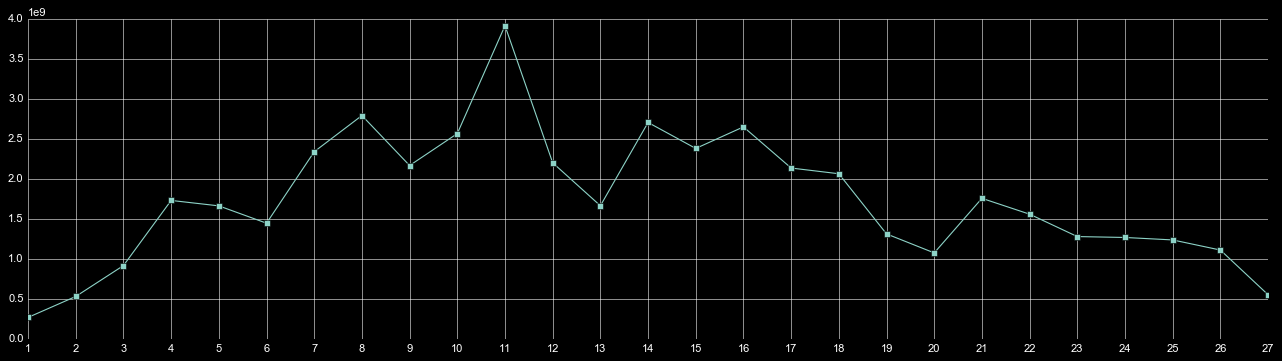

In [432]:
plt.figure(figsize=(20,5))
plt.plot(gpData.PAY_DATE_S, gpData.REALTIME_PM, marker='s')
plt.xticks(gpData.PAY_DATE_S, gpData.PAY_DATE_S.apply(lambda d: d.day))
plt.show()